In [16]:
#https://richliao.github.io/supervised/classification/2016/12/26/textclassifier-HATN/
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence

#my module
import evaluation
import encode
import _model_

import word_embedding
embedding_matrix = None

#### dataset
dataset from kaggle https://www.kaggle.com/c/word2vec-nlp-tutorial/data
(data was tokenized already on my own)

In [17]:
def read_file(path_file):
    print("read path: ",path_file)
    df= pd.read_csv(path_file, index_col=0)
    return df

path_read_file= 'tmp/labeledTraintoken.csv'
df= read_file(path_read_file)    
df.tail()

read path:  tmp/labeledTraintoken.csv


,id,sentiment,review
24995,3453_3,0,It like consideration IMDb review film review ...
24996,5064_1,0,I believe make film Completely unnecessary The...
24997,10905_3,0,Guy loser girl need build pick strong successf...
24998,10194_3,0,This minute documentary Buñuel make early Spai...
24999,8478_8,1,I movie child break heart No story unfinished ...


#### parameters setting

In [18]:
max_review_length = 500

#### data preprocessing
1. encode: token, encoding number from string with vocabulary
2. padding as the same length 

In [19]:
def preprocessing(df, max_review_length):
    rate_train_test_split= 0.2
    
    x, y, map_vocabulary = encode.encode_data(df) 
    vocabulary= map_vocabulary.values()
    vocabulary_size= len(vocabulary)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= rate_train_test_split, random_state=0)
    print( len(X_train), len(y_train), vocabulary_size )

    #truncate and pad input sequences
    X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
    X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
    
    return X_train, X_test, y_train, y_test, x, y, vocabulary, vocabulary_size

X_train, X_test, y_train, y_test, x, y, vocabulary, vocabulary_size = preprocessing(df, max_review_length)

/Users/h/Desktop/sentiment analysis/work/encode.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_text = [s.split(" ") for s in df['review'].as_matrix()]
/Users/h/Desktop/sentiment analysis/work/encode.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y=df['sentiment'].as_matrix()


20000 20000 73290


#### word embedding

In [20]:
if not embedding_matrix:
    embedding_matrix= word_embedding.google_news(vocabulary)    

word embedding...
(73290, 300)
word embedding loading done


In [21]:
def train_model(model, X_train, X_test, y_train, y_test, epochs=3, batch_size=32):
    h= model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
    evaluation.accuracy_curve(h)
    evaluation.evaluate_model(model, X_test, y_test)

#### training CNN
max_review_length = 100:  epochs= 6
max_review_length = 500:  epochs= 5

/Users/h/Desktop/sentiment analysis/work/_model_.py:34: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=2, strides=1, padding="valid")`
  subsample_length=1)(graph_in)
/Users/h/Desktop/sentiment analysis/work/_model_.py:35: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  pool = MaxPooling1D(pool_length=2)(conv)
/Users/h/Desktop/sentiment analysis/work/_model_.py:34: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3, strides=1, padding="valid")`
  subsample_length=1)(graph_in)
/Users/h/Desktop/sentiment analysis/work/_model_.py:34: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4, strides=1, padding="valid")`
  subsample_length=1)(graph_in)
/Users/h/Desktop/sentiment analysis/work/_model_.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 300)          21987000  
_________________________________________________________________
dropout_11 (Dropout)         (None, 500, 300)          0         
_________________________________________________________________
model_6 (Model)              (None, 95488)             345984    
_________________________________________________________________
dense_13 (Dense)             (None, 50)                4774450   
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
activation_11 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
__________

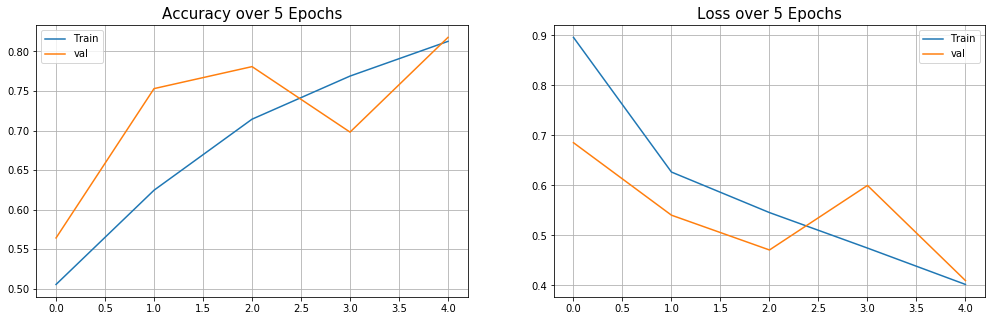

5000/5000 [==============================] - 38s 8ms/step
Accuracy: 81.78%
precision: 85.04%
recall: 76.26%
fscore: 80.41%


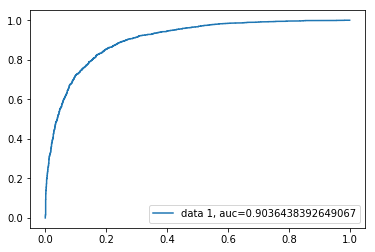

In [23]:
epochs= 5
batch_size=64    
model= _model_.cnn(vocabulary_size, max_review_length, embedding_matrix)
train_model(model, X_train, X_test, y_train, y_test, epochs, batch_size)

#### training LSTM
max_review_length = 100:  epochs= 5
max_review_length = 500:  epochs= 14

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 300)          21987000  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 201       
Total params: 22,308,001
Trainable params: 321,001
Non-trainable params: 21,987,000
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/14
20000/20000 [==============================] - 682s 34ms/step - loss: 0.6413 - acc: 0.6276 - val_loss: 0.6302 - val_acc: 0.6434
Epoch 2/14
20000/20000 [==============================] - 678s 34ms/step - loss: 0.5972 - acc: 0.6809 - val_loss: 0.5445 - val_acc: 0.7268
Epoch 3/14
20000/20000 [==============================] 

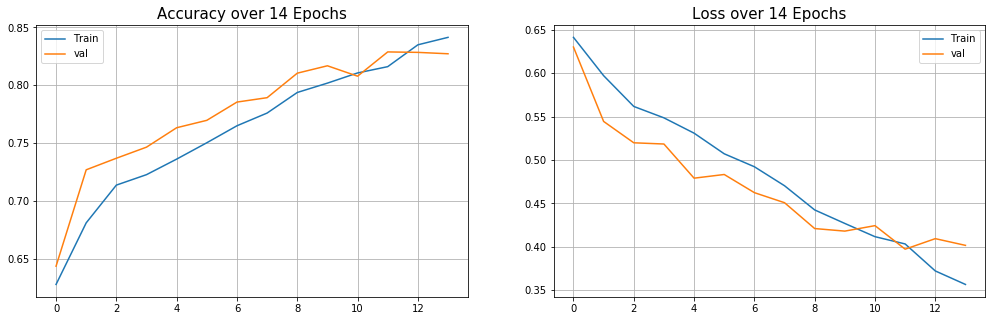

5000/5000 [==============================] - 87s 17ms/step
Accuracy: 82.72%
precision: 86.22%
recall: 77.08%
fscore: 81.40%


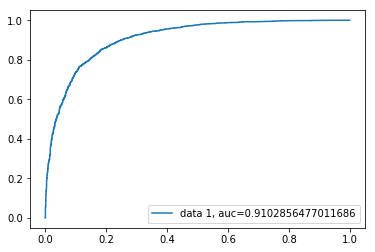

In [26]:
epochs= 14
batch_size=64    
model= _model_.lstm(vocabulary_size, max_review_length, embedding_matrix)
train_model(model, X_train, X_test, y_train, y_test, epochs, batch_size)